In [ ]:
!nvidia-smi

Fri Aug 18 14:16:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

INSTALAMOS LOS NECESARIO


In [ ]:
!pip install -q -U watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.6 MB/s eta 0:00:00


In [ ]:
!pip install -qq transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.9 MB/s eta 0:00:00


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy       : 1.23.5
pandas      : 1.5.3
torch       : 2.0.1+cu118
transformers: 4.31.0



IMPORTAMOS LAS LIBRERIAS NECESARIAS/ALGUNOS DATOS QUE USAREMOS

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup,BertForSequenceClassification
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F # esta funcion no fue incluida
import os

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

DESCARGAMOS NUESTRAS BASE DE DATOS DE REVIEWS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df= pd.read_csv("/content/drive/MyDrive/Henry/PROYECTO FINAL/datasets/cl_reviews_gm.csv")
new_column_names = {'text': 'content', 'Sentimiento_Mapeado': 'sentiment','rating': 'score'}

df.rename(columns=new_column_names, inplace=True)
column_name_to_drop = 'sentiment'
df = df.drop(column_name_to_drop, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250500 entries, 0 to 250499
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   review_id     250500 non-null  object
 1   score         250500 non-null  int64 
 2   content       250500 non-null  object
 3   cleaned_text  250500 non-null  object
dtypes: int64(1), object(3)
memory usage: 7.6+ MB


In [ ]:
df.head(5)

,review_id,rating,text,cleaned_text,Sentimiento_Mapeado
0,b7c24acd-2d76-447c-9e85-f374ac5118d8,5,Great location. Decent prices with a wide vari...,great location decent price wide variety choic...,Positivo
1,b2d234e1-07f3-4f17-815f-83a91974ba3e,5,Fantastic,fantastic,Positivo
2,a051d720-e32e-4c71-bef0-a540def77975,5,Good Chicken,good chicken,Positivo
3,b402f52a-f5f0-4ba7-b3ef-8823f5cd8515,4,Drive in quick. Great smoothie and nuggets,drive quick great smoothie nugget,Positivo
4,db5d5847-d189-46e4-8131-05d7eaf95990,5,Finally a good Asian restaurant in Navarre! We...,finally good asian restaurant navarre shrimp v...,Positivo


In [ ]:
!gdown --id 1eXcyqhvjKZpXQXplzrcFMbv_DiVSUdQQ
#!gdown --id 1XNNpuv8CyrEsnitcA_o_ELDj1lB_ozuY

Downloading...
From: https://drive.google.com/uc?id=1eXcyqhvjKZpXQXplzrcFMbv_DiVSUdQQ
To: /content/reviewsV2.csv
7.21MB [00:00, 44.1MB/s]


EXPLORAMOS NUESTROS DATOS

In [ ]:
df = pd.read_csv("reviewsV2.csv")
df.head()

,Unnamed: 0,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId,Unnamed: 12,Unnamed: 13
0,0,gp:AOqpTOH4B-QZyWwoqUcGFpdcZtTM7IH-LLXi27wVA1y...,alexis cazares,https://lh3.googleusercontent.com/-O9lnImjLpdY...,"Con la actualización, no me deja acceder a mi ...",1,13921.0,6.0.022.02.45,2020-02-24 17:52:25,NaN,NaN,most_relevant,com.google.android.apps.classroom,NaN,NaN
1,1,gp:AOqpTOGRJrkVPTyauYWt8h4hemaO6JNq2c3wvHzVtXN...,Aida Rus,https://lh3.googleusercontent.com/a-/AOh14Gjvh...,No me deja acceder con el correo institucional...,1,3429.0,6.0.022.02.40,2020-02-01 07:21:33,NaN,NaN,most_relevant,com.google.android.apps.classroom,NaN,NaN
2,2,gp:AOqpTOF_sJHyGpjz3mtFe_XISIVDelffHIAamcKpTGC...,Alexis Ven,https://lh3.googleusercontent.com/-ok0eZU2YcyA...,Se me hace fastidioso usar esta app cuando hay...,1,3727.0,6.4.181.03.30,2020-05-28 09:09:01,NaN,NaN,most_relevant,com.google.android.apps.classroom,NaN,NaN
3,3,gp:AOqpTOEKZZC0vvbdR96SbSIzUt-DMlOe-FCU5QJr2fu...,najwaa_ 96,https://lh3.googleusercontent.com/-J7KHIad9syg...,"La peor aplicación del mundo, y lo mejor que p...",1,3076.0,6.4.181.03.44,2020-06-03 06:26:08,NaN,NaN,most_relevant,com.google.android.apps.classroom,NaN,NaN
4,4,gp:AOqpTOHHU-NyjzITN0i0dm9XDMC1DNn_uppNiQsk72t...,The Eoster,https://lh3.googleusercontent.com/a-/AOh14GhOv...,No me deja entrar desde que se actualizo... Ar...,1,3100.0,6.0.022.05.45c,2020-02-23 23:25:55,NaN,NaN,most_relevant,com.google.android.apps.classroom,NaN,NaN


In [ ]:
df.shape # LAS DIMENSIONES DE NEUSTROS DATOS
df.info() # LA INFORMACION COMO LOS CAMPOS

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250500 entries, 0 to 250499
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   review_id     250500 non-null  object
 1   score         250500 non-null  int64 
 2   content       250500 non-null  object
 3   cleaned_text  250500 non-null  object
dtypes: int64(1), object(3)
memory usage: 7.6+ MB


VEMOS NUESTROS DATOS

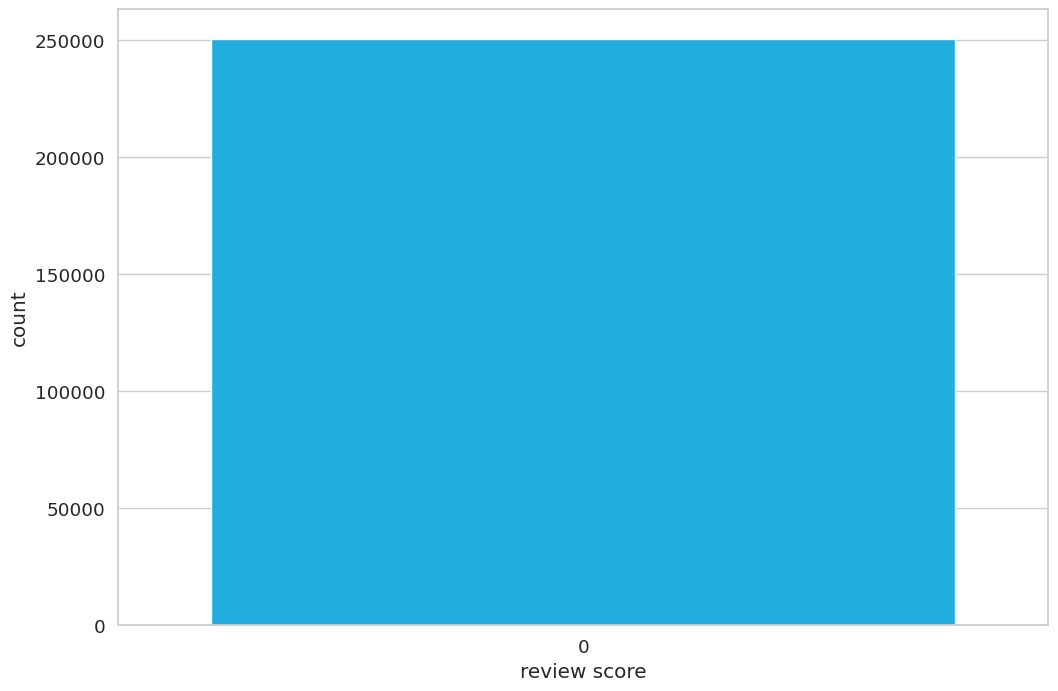

In [ ]:
sns.countplot(df.score)
plt.xlabel('review score');

CONVERTIMOS NUESTROS DATOS

In [ ]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else:
    return 2

df['sentiment'] = df.score.apply(to_sentiment)


In [ ]:
class_names = ['Negativo', 'Neutral', 'Positivo']

Text(0.5, 0, 'Sentimiento del comentario')

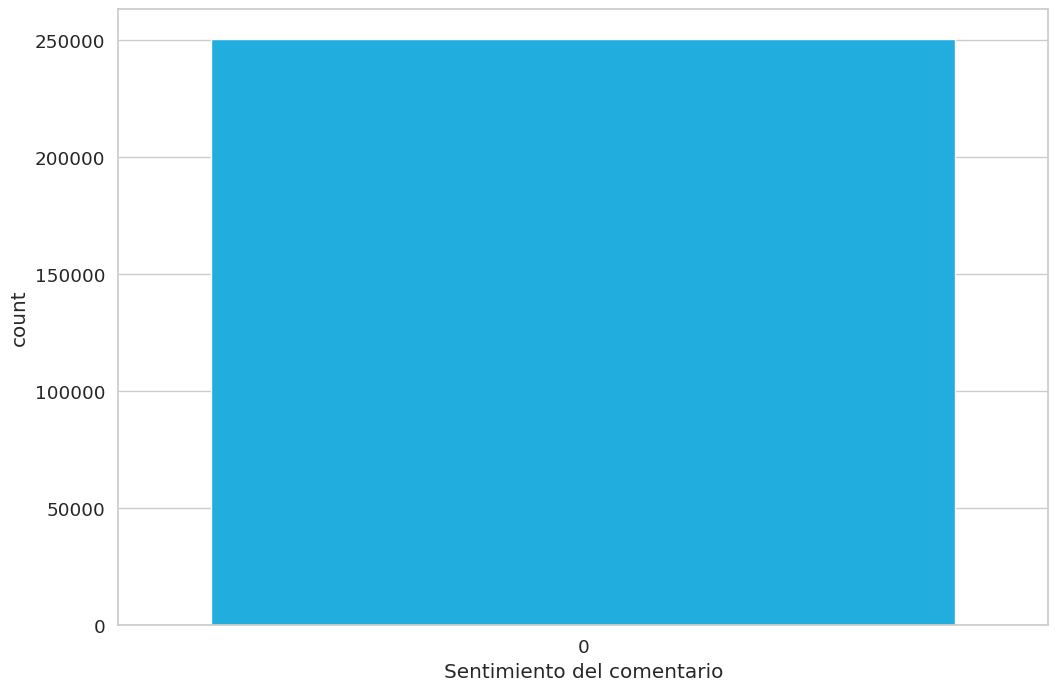

In [ ]:
ax = sns.countplot(df.sentiment)
plt.xlabel('Sentimiento del comentario')
#ax.set_xticklabels(class_names);

In [ ]:
conteo_ratings = df['score'].value_counts()
print(conteo_ratings)

3    83500
5    64261
1    51850
2    31650
4    19239
Name: score, dtype: int64


In [ ]:
conteo_sent = df['sentiment'].value_counts()
print(conteo_sent)

2    83500
0    83500
1    83500
Name: sentiment, dtype: int64


# PROCESAMIENTO DE NUESTROS DATOS

Cargamos nuestro modelo/ usaremos el modelo beto

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'


In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
sample_txt = 'THE ATTENTION WAS GOOD BUT IT DELAYED.'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: THE ATTENTION WAS GOOD BUT IT DELAYED.
   Tokens: ['the', 'attention', 'was', 'good', 'but', 'it', 'delayed', '.']
Token IDs: [1996, 3086, 2001, 2204, 2021, 2009, 8394, 1012]


In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id,tokenizer.cls_token, tokenizer.cls_token_id,tokenizer.pad_token, tokenizer.pad_token_id,tokenizer.unk_token, tokenizer.unk_token_id

('[SEP]', 102, '[CLS]', 101, '[PAD]', 0, '[UNK]', 100)

In [ ]:
#necesitmoas tulizar la forma en como bert recibe nuestros reviews
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  truncation=True,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101,  2771,  2053, 19908,  9686,  5348,  1061, 25176,  2139,  7304,
         1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0])

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'the',
 'attention',
 'was',
 'good',
 'but',
 'it',
 'delayed',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

Buscamos la mayor logintud dentro de nuestros reviews

In [ ]:
token_lens = []

for txt in df.content:
  tokens = tokenizer.encode(txt, max_length=512,truncation=True)
  token_lens.append(len(tokens))

<ipython-input-44-4dbe9bd8b56e>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


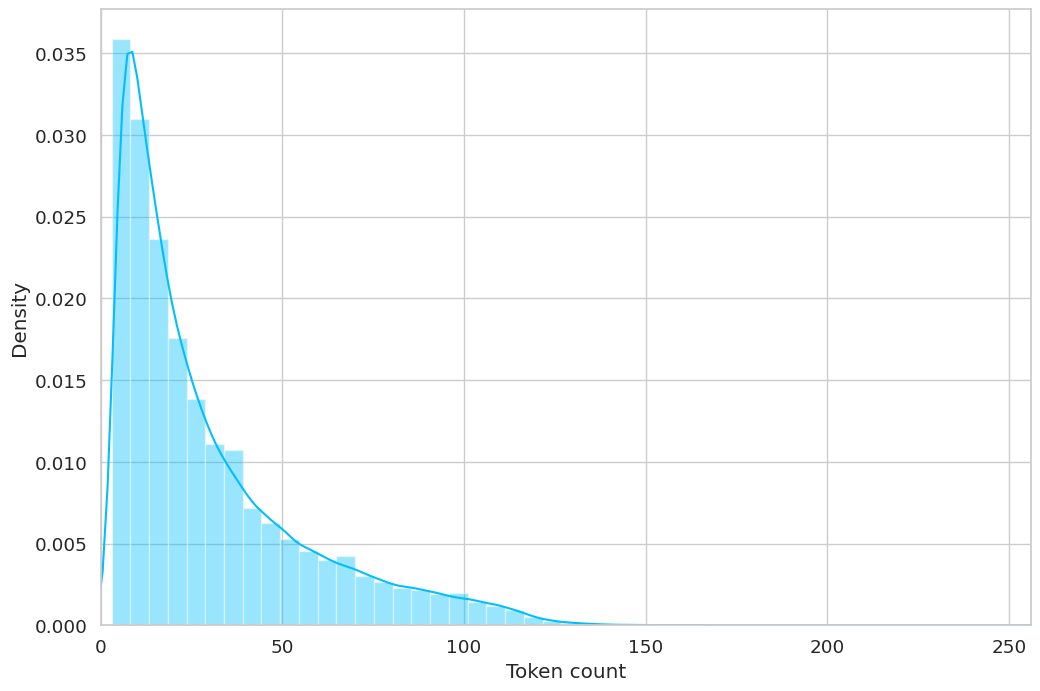

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [ ]:
MAX_LEN = 160

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      truncation=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((225450, 5), (12525, 5), (12525, 5))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


# ANALISIS DE SENTIMIENTO CON BERT

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask'],
  return_dict = False
)


In [ ]:
print(type(encoding['input_ids']))
print(type(encoding['attention_mask']))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [ ]:
print(last_hidden_state.shape)
print(bert_model.config.hidden_size)
print(pooled_output.shape)

torch.Size([1, 32, 768])
768
torch.Size([1, 768])


Creamos nuestra clase que sera la encargada de el mannejo


In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict = False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape)


torch.Size([16, 160])
torch.Size([16, 160])


Obtenemos la probabilidades utilizando softmax en la salida

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2718, 0.4883, 0.2399],
        [0.2712, 0.4451, 0.2837],
        [0.3597, 0.3416, 0.2988],
        [0.2112, 0.5337, 0.2551],
        [0.2989, 0.4727, 0.2283],
        [0.5153, 0.3188, 0.1658],
        [0.2513, 0.4557, 0.2931],
        [0.2619, 0.4024, 0.3357],
        [0.3130, 0.4047, 0.2823],
        [0.3829, 0.3366, 0.2805],
        [0.4159, 0.3259, 0.2582],
        [0.3262, 0.3517, 0.3221],
        [0.4018, 0.2601, 0.3381],
        [0.3748, 0.3708, 0.2544],
        [0.3866, 0.3674, 0.2460],
        [0.3510, 0.3827, 0.2663]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

**ENTRENAMIENTO**

In [ ]:
EPOCHS = 4 # la documentacion señala que lo ideal es 3 a 4 epocas pero haremos las pruebas

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Se recomienda los siguientes datos segun la documentacion:
1.   Batch size: 16, 32
2.   Learning rate (Adam): 5e-5, 3e-5, 2e-5
3.   Number of epochs: 2, 3, 4








In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Funcion para evaluar nuestro modelo

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0
output_dir = './model_save/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), output_dir+'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/4
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.war

KeyboardInterrupt: ignored

Mostramos el resultados de nuestro entrenamiento

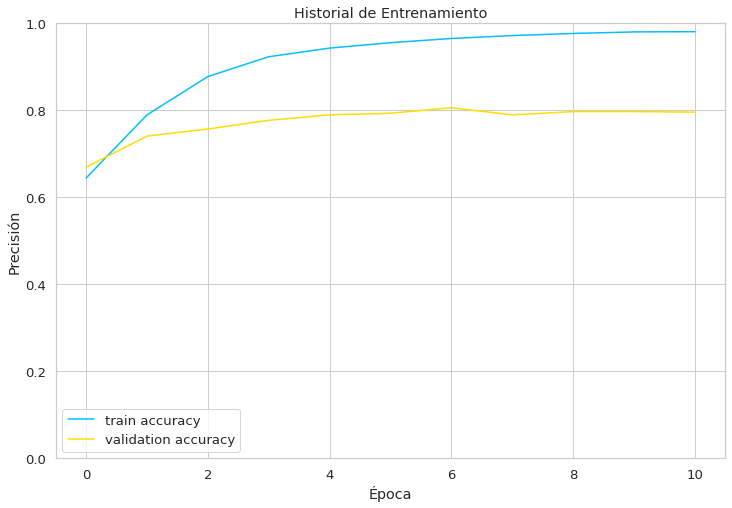

In [ ]:
plt.plot(history['train_acc'], label='Precisición de entrenamiento')
plt.plot(history['val_acc'], label='Precesición de validación')

plt.title('Historial de Entrenamiento')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend()
plt.ylim([0, 1]);

Evaluamos nuestro modelo entrenado

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8075

Creamos una funcion que nos ayude para predecir nuestro modelo

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)
print(y_test)
print(y_pred_probs)
print(classification_report(y_test, y_pred, target_names=class_names))

tensor([2, 0, 0, 1, 1, 2, 2, 0, 2, 1, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 1,
        2, 0, 0, 1, 0, 0, 1, 0, 2, 2, 0, 2, 1, 1, 1, 2, 0, 2, 2, 2, 0, 2, 2, 1,
        1, 2, 1, 0, 0, 0, 0, 2, 1, 2, 1, 0, 2, 1, 0, 0, 2, 2, 0, 2, 2, 2, 1, 0,
        2, 2, 2, 2, 1, 0, 2, 2, 2, 1, 0, 1, 1, 1, 2, 1, 1, 0, 0, 1, 0, 0, 1, 2,
        2, 1, 0, 2, 2, 0, 2, 2, 1, 2, 1, 0, 0, 2, 2, 2, 0, 1, 0, 2, 2, 0, 0, 2,
        0, 0, 1, 1, 2, 1, 1, 0, 0, 2, 0, 2, 0, 2, 2, 1, 2, 1, 1, 1, 1, 1, 0, 0,
        2, 0, 2, 2, 0, 0, 1, 1, 0, 2, 2, 1, 1, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2,
        0, 0, 2, 2, 0, 2, 2, 0, 1, 2, 0, 2, 0, 0, 1, 2, 0, 2, 1, 0, 2, 1, 2, 1,
        2, 2, 0, 0, 0, 2, 0, 2, 2, 1, 0, 0, 2, 2, 1, 1, 0, 1, 2, 2, 1, 0, 1, 1,
        2, 0, 1, 0, 2, 2, 2, 1, 1, 1, 0, 1, 1, 0, 0, 2, 0, 1, 2, 2, 2, 2, 0, 0,
        0, 2, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 2, 0, 1, 0, 2, 1, 2, 0, 1,
        0, 0, 0, 1, 1, 0, 2, 0, 1, 2, 2, 0, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1,
        0, 1, 0, 2, 1, 0, 2, 1, 2, 2, 0,

Creamos una funcion para mostrar la matriz de confusion

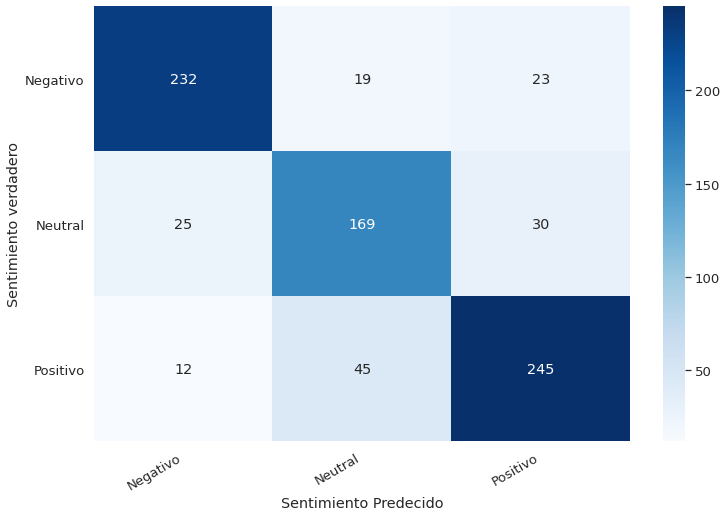

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('Sentimiento verdadero')
  plt.xlabel('Sentimiento Predecido');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

Cuando comenze con brainly fueron hace 2 años y me funcionaba bien las
respuestas coherentes y precisas pero cuando lo volvi a usarlo yo
quería preguntar mi duda y cuando me dieron la respuesta era inútil no
tenía ningún sentido "solo contestan para ganar puntos y suban de
rango" revise el perfil del usuario que me contesto mi duda y me di
con la sorpresa de que todas sus respuestas eran iguales y me enoje y
quiero que le quiten la cuenta a Pandaarmy21 y a otros usuarios que
hacen lo mismo.

True sentiment: negative


haremos una funcion para facilitar


In [ ]:
review_text = "deben mejorar no me permite guardar"

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: deben mejorar no me permite guardar
Sentiment  : negative


Guardamos nuestro modelo

In [ ]:
from google.colab import drive


Verificamos si nuestro modelo se guardo

In [ ]:
#%cd /root/model_save/drive/
%ls


best_model_state.bin


In [ ]:
#Guardamos el Tokenize
tokenizer.save_pretrained(output_dir)


Saving directory (./model_save/) should be a directory


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

#!cp -r /root/model_save/best_model_state.bin "./drive/My drive/Colab Notebooks"


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!cp -r /root/model_save/best_model_state.bin "/content/gdrive/My Drive/Colab Notebooks"

CARGAMOS NUESTRO MODELO ENTRENADO

In [ ]:
!gdown --id 1nEP1pkj3kMLHg-OwIluSHfgsDEXkqmdO


Downloading...
From: https://drive.google.com/uc?id=1nEP1pkj3kMLHg-OwIluSHfgsDEXkqmdO
To: /root/model_save/drive/best_model_state.bin
439MB [00:02, 193MB/s]


In [ ]:
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)


In [ ]:
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)
print(y_test)
print(y_pred_probs)

print(classification_report(y_test, y_pred, target_names=class_names))

tensor([0, 0, 2, 0, 1, 1, 1, 2, 2, 0, 2, 0, 2, 1, 1, 0, 2, 1, 2, 1, 2, 0, 0, 1,
        0, 0, 1, 2, 1, 0, 1, 2, 1, 1, 0, 2, 0, 2, 0, 1, 2, 2, 1, 0, 1, 0, 2, 1,
        2, 1, 2, 0, 1, 2, 2, 0, 1, 1, 1, 2, 2, 2, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1,
        2, 1, 0, 1, 0, 2, 1, 0, 0, 1, 2, 1, 0, 2, 2, 2, 0, 1, 0, 2, 2, 1, 0, 0,
        2, 0, 1, 0, 1, 1, 0, 1, 2, 2, 2, 2, 2, 0, 2, 0, 1, 2, 0, 0, 2, 0, 0, 0])
tensor([[9.9958e-01, 1.9918e-04, 2.2337e-04],
        [9.9229e-01, 4.8571e-03, 2.8523e-03],
        [1.3134e-03, 1.0103e-03, 9.9768e-01],
        [9.6280e-01, 1.1847e-02, 2.5357e-02],
        [4.6364e-04, 9.9883e-01, 7.0224e-04],
        [4.0012e-04, 9.9862e-01, 9.7823e-04],
        [4.1607e-04, 9.9929e-01, 2.9123e-04],
        [7.0574e-04, 9.9808e-01, 1.2142e-03],
        [7.8669e-04, 1.5907e-03, 9.9762e-01],
        [9.9844e-01, 6.0735e-04, 9.5532e-04],
        [6.5907e-03, 5.2910e-01, 4.6430e-01],
        [9.9944e-01, 2.6159e-04, 2.9825e-04],
        [9.9762e-01, 1.9149e-03, 4.6485e-04],
 